# Figure Legends Visualization for the Paper

# Figure 3

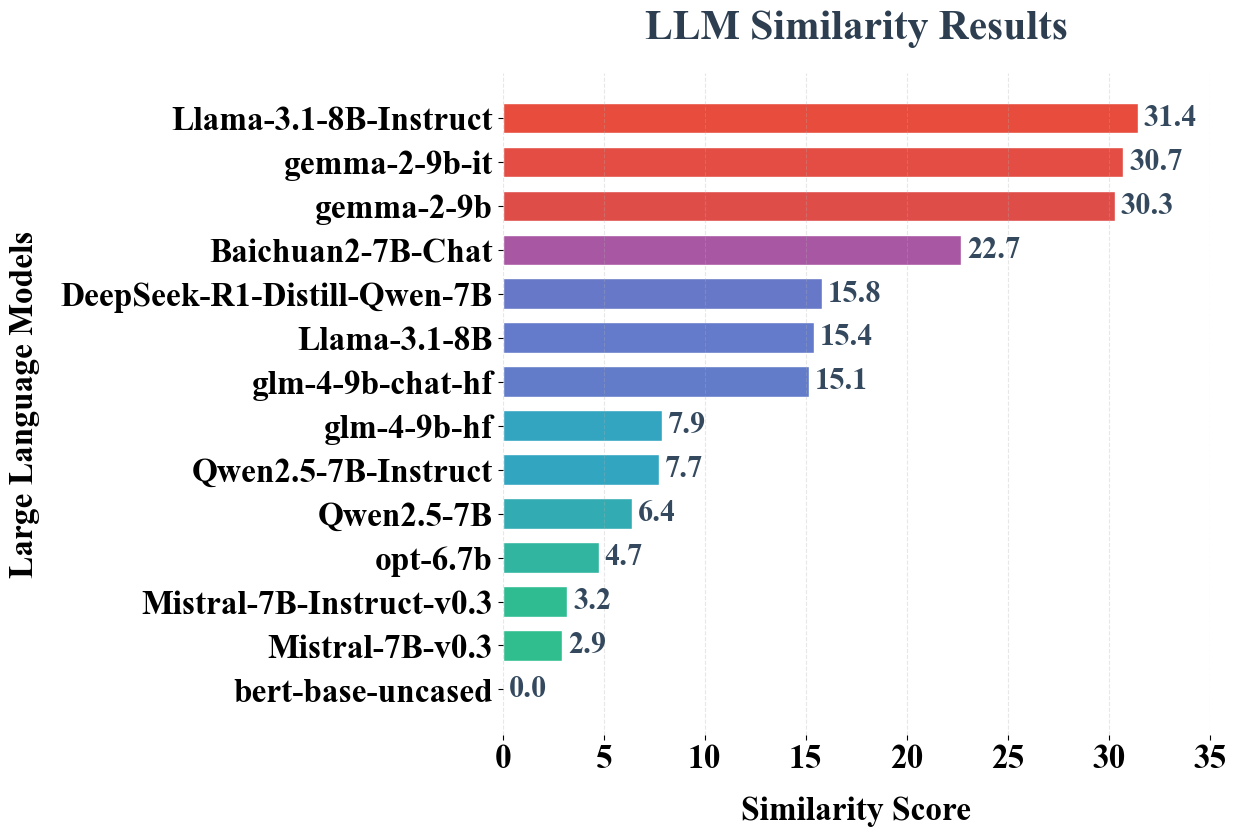

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Global font settings: Times New Roman + Bold
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'pdf.fonttype': 42,  # Embed TrueType to ensure selectable text in PDF
    'ps.fonttype': 42
})

# Data preparation
data = {
    'Llama-3.1-8B-Instruct': 31.42,
    'gemma-2-9b-it': 30.69,
    'gemma-2-9b': 30.29,
    'Baichuan2-7B-Chat': 22.68,
    'DeepSeek-R1-Distill-Qwen-7B': 15.81,
    'Llama-3.1-8B': 15.41,
    'glm-4-9b-chat-hf': 15.14,
    'Qwen2.5-7B-Instruct': 7.74,
    'glm-4-9b-hf': 7.87,
    'Qwen2.5-7B': 6.40,
    'opt-6.7b': 4.74,
    'Mistral-7B-Instruct-v0.3': 3.20,
    'Mistral-7B-v0.3': 2.94,
    'bert-base-uncased': 0
}

# Sort data
sorted_data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))

# Create custom gradient colors
colors = ["#2ecc71", "#3498db", "#9b59b6", "#e74c3c"]  # Green → Blue → Purple → Red
cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)
norm = plt.Normalize(min(data.values()), max(data.values()))
color_values = [cmap(norm(v)) for v in sorted_data.values()]

# Create chart (increase chart size to accommodate larger fonts)
plt.figure(figsize=(14, 10))

# Draw bar chart
bar_plot = plt.barh(
    list(sorted_data.keys()),
    list(sorted_data.values()),
    color=color_values,
    edgecolor='white',
    linewidth=1,
    height=0.7
)

# Set axis tick font (Times New Roman + Bold)
plt.yticks(fontsize=24, fontweight='bold')
plt.xticks(fontsize=24, fontweight='bold')

# Add data labels (Bold + Times New Roman)
for bar in bar_plot:
    width = bar.get_width()
    plt.text(
        width + 0.3,
        bar.get_y() + bar.get_height()/2,
        f'{width:.1f}',
        ha='left',
        va='center',
        fontsize=22,
        fontweight='bold',
        color='#34495e'
    )

# Beautify chart
plt.gca().invert_yaxis()  # Highest value on top
plt.xlabel('Similarity Score', fontsize=24, labelpad=15, fontweight='bold')
plt.ylabel('Large Language Models', fontsize=24, labelpad=15, fontweight='bold')
plt.title(
    'LLM Similarity Results',
    fontsize=30,
    pad=25,
    color='#2c3e50',
    fontweight='bold'
)

# Set grid and borders
plt.grid(axis='x', linestyle='--', alpha=0.3)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Adjust layout
plt.xlim(0, 35)
plt.tight_layout(pad=3)

# Save high-quality PDF
plt.savefig('llm_similarity.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

# Figure 4 

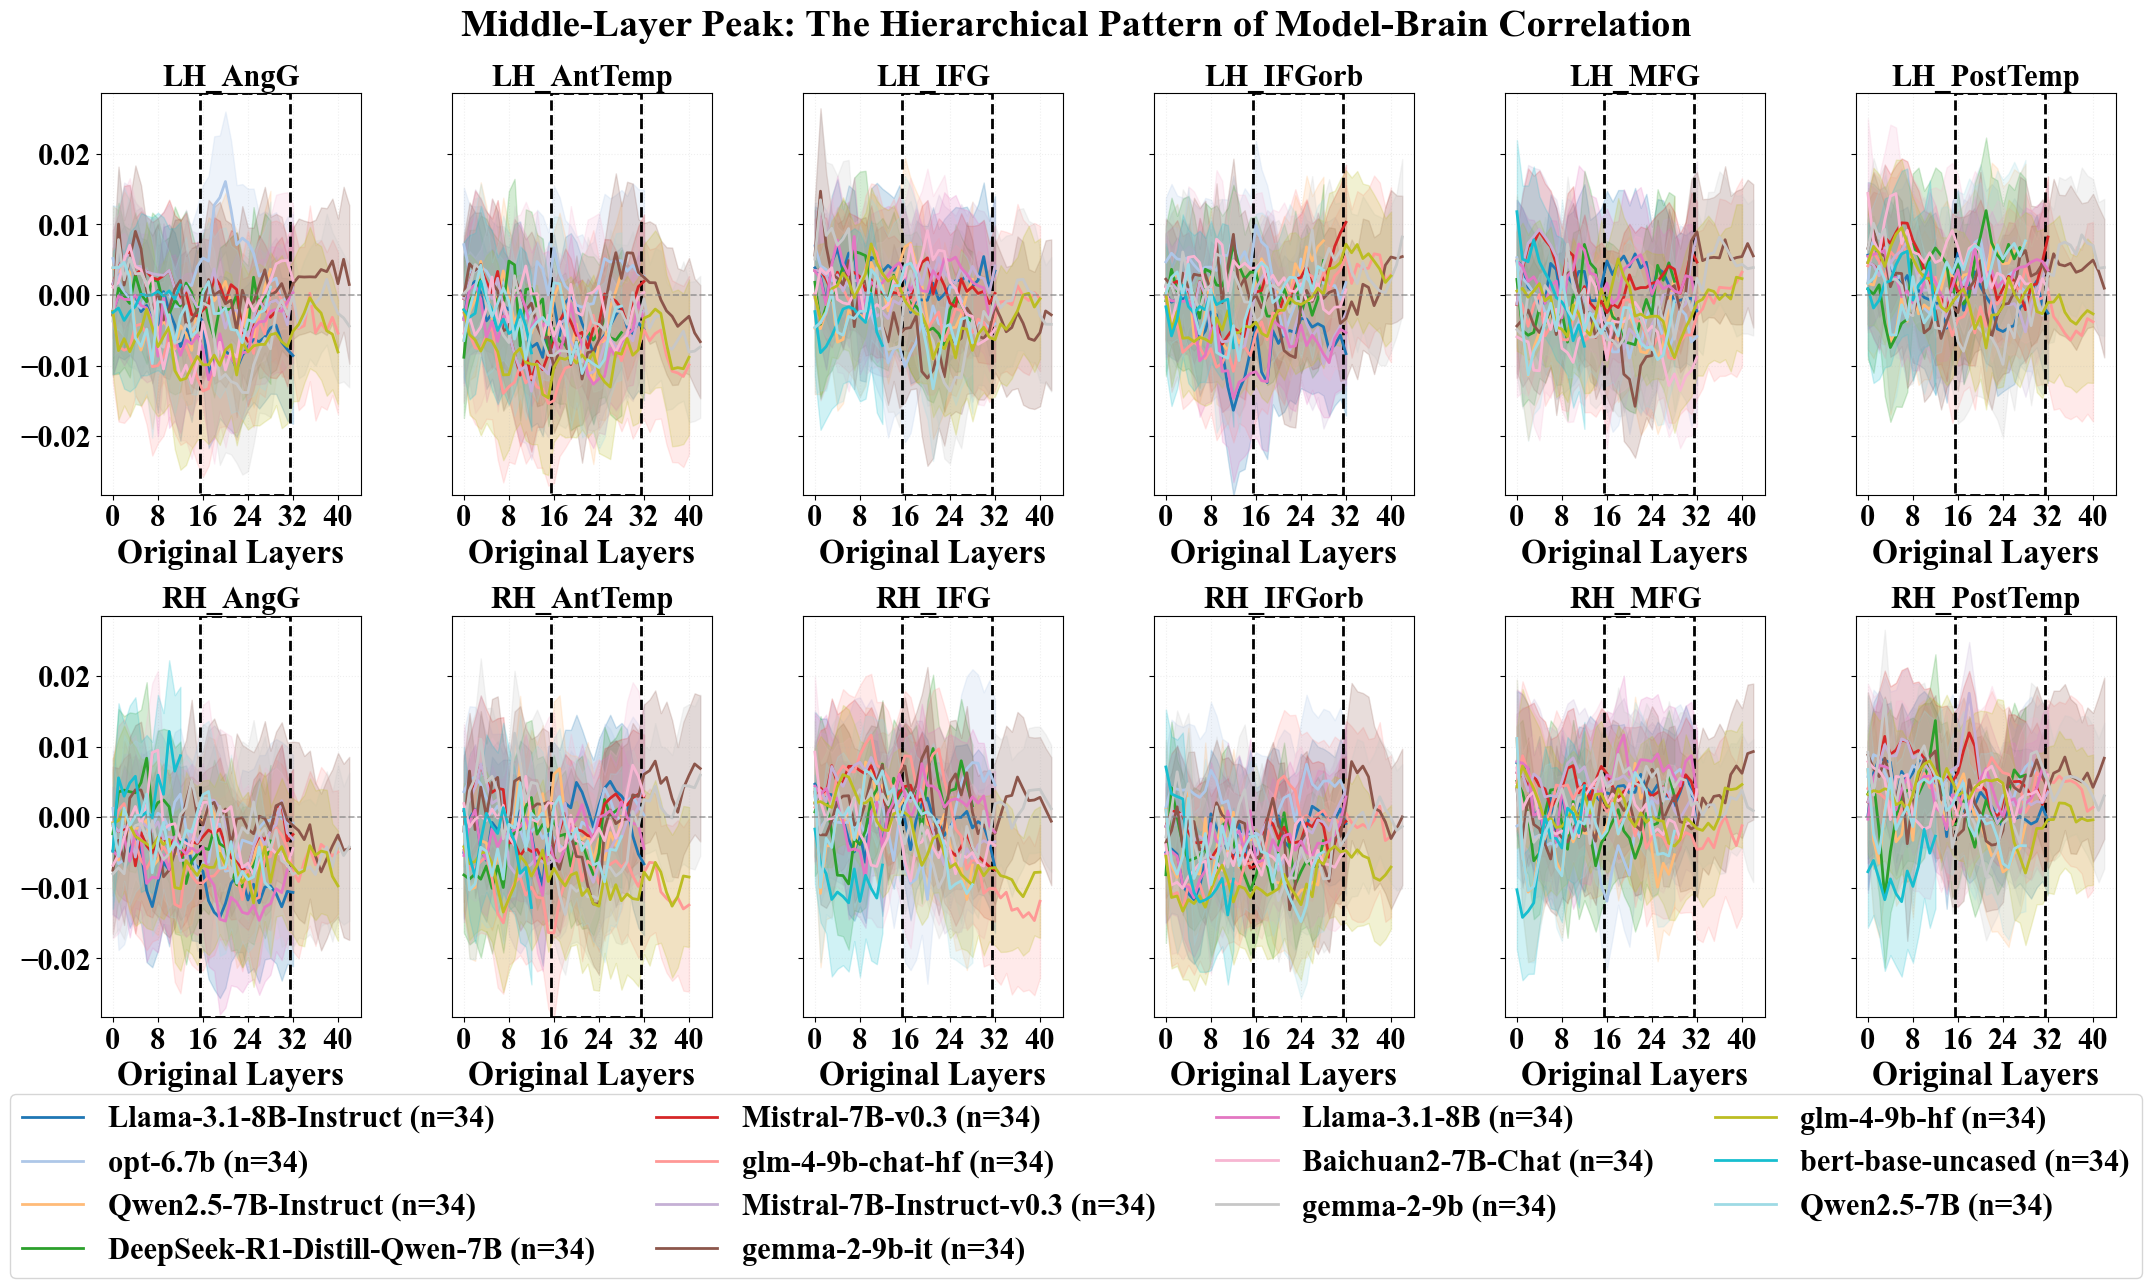

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.interpolate import interp1d
from scipy.stats import sem, t
from matplotlib.patches import Rectangle

# Global font settings: Times New Roman + Bold + 22pt or larger
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 22,
    'font.weight': 'bold',
    'axes.labelsize': 24,
    'axes.titlesize': 22,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'legend.fontsize': 22,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Configuration parameters
base_path = 'results_language_scheme1/'
rois = ['LH_AngG', 'LH_AntTemp', 'LH_IFG', 'LH_IFGorb', 'LH_MFG', 'LH_PostTemp',
        'RH_AngG', 'RH_AntTemp', 'RH_IFG', 'RH_IFGorb', 'RH_MFG', 'RH_PostTemp']
confidence_level = 0.95  # 95% confidence interval
models = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
colors = plt.cm.tab20(np.linspace(0, 1, len(models)))

# Create 2x6 subplot grid (increase canvas size to accommodate large fonts)
fig, axes = plt.subplots(2, 6, figsize=(26, 12), sharey=True)
plt.subplots_adjust(hspace=0.3, wspace=0.35)

# Iterate through all ROIs
for i, roi in enumerate(rois):
    ax = axes[i // 6, i % 6]
    model_results = {}
    
    # Process data for each model
    for model in models:
        model_path = os.path.join(base_path, model)
        all_subject_corrs = []
        layer_counts = set()
        
        for subj in range(34):
            file_path = os.path.join(model_path, f'subj_{subj}_{roi}.npz')
            if not os.path.exists(file_path):
                continue
            
            data = np.load(file_path)
            correlations = data['correlations']
            original_layers = len(correlations)
            layer_counts.add(original_layers)
            
            all_subject_corrs.append(correlations)
        
        if all_subject_corrs:
            if len(layer_counts) > 1:
                print(f"Warning: Model {model} has different layer counts across subjects in ROI {roi}: {layer_counts}")
                continue
            
            all_subject_corrs = np.array(all_subject_corrs)
            n_subjects = len(all_subject_corrs)
            original_layers = all_subject_corrs.shape[1]
            
            mean = np.mean(all_subject_corrs, axis=0)
            stderr = sem(all_subject_corrs, axis=0)
            h = stderr * t.ppf((1 + confidence_level) / 2, n_subjects - 1)
            
            model_results[model] = {
                'mean': mean,
                'ci_lower': mean - h,
                'ci_upper': mean + h,
                'n_subjects': n_subjects,
                'layers': np.arange(original_layers)
            }
    
    # Plot subplot for current ROI
    for model, data in model_results.items():
        color = colors[models.index(model)]
        layers = data['layers']
        
        ax.fill_between(
            layers, data['ci_lower'], data['ci_upper'],
            color=color, alpha=0.2, label='_nolegend_'
        )
        
        ax.plot(
            layers, data['mean'], color=color, linewidth=2.0,
            label=f"{model} (n={data['n_subjects']})"
        )
    
    # Dynamically set X-axis
    max_layers = max([d['layers'][-1] for d in model_results.values()], default=0)
    ax.set_xticks(np.arange(0, max_layers + 1, max(1, max_layers // 5)))
    ax.set_xlabel('Original Layers', fontsize=24)
    ax.set_title(roi, fontsize=22, pad=6)
    ax.grid(alpha=0.2, linestyle=':')
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.2, alpha=0.7)
    
    # Add dashed box for layers 16-32 while maintaining y-axis range
    if max_layers >= 31:
        current_ylim = ax.get_ylim()
        rect = Rectangle(
            (15.5, current_ylim[0]),
            16,
            current_ylim[1] - current_ylim[0],
            linewidth=2.0,
            linestyle='--',
            edgecolor='black',
            facecolor='none'
        )
        ax.add_patch(rect)
        ax.set_ylim(current_ylim)

fig.suptitle(
    'Middle-Layer Peak: The Hierarchical Pattern of Model-Brain Correlation',
    fontsize=28,
    fontweight='bold',
    y=0.95
)

# Global legend (font size 22 or larger)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=4,
    fontsize=22
)

plt.savefig('all_ROIs_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Figure 5

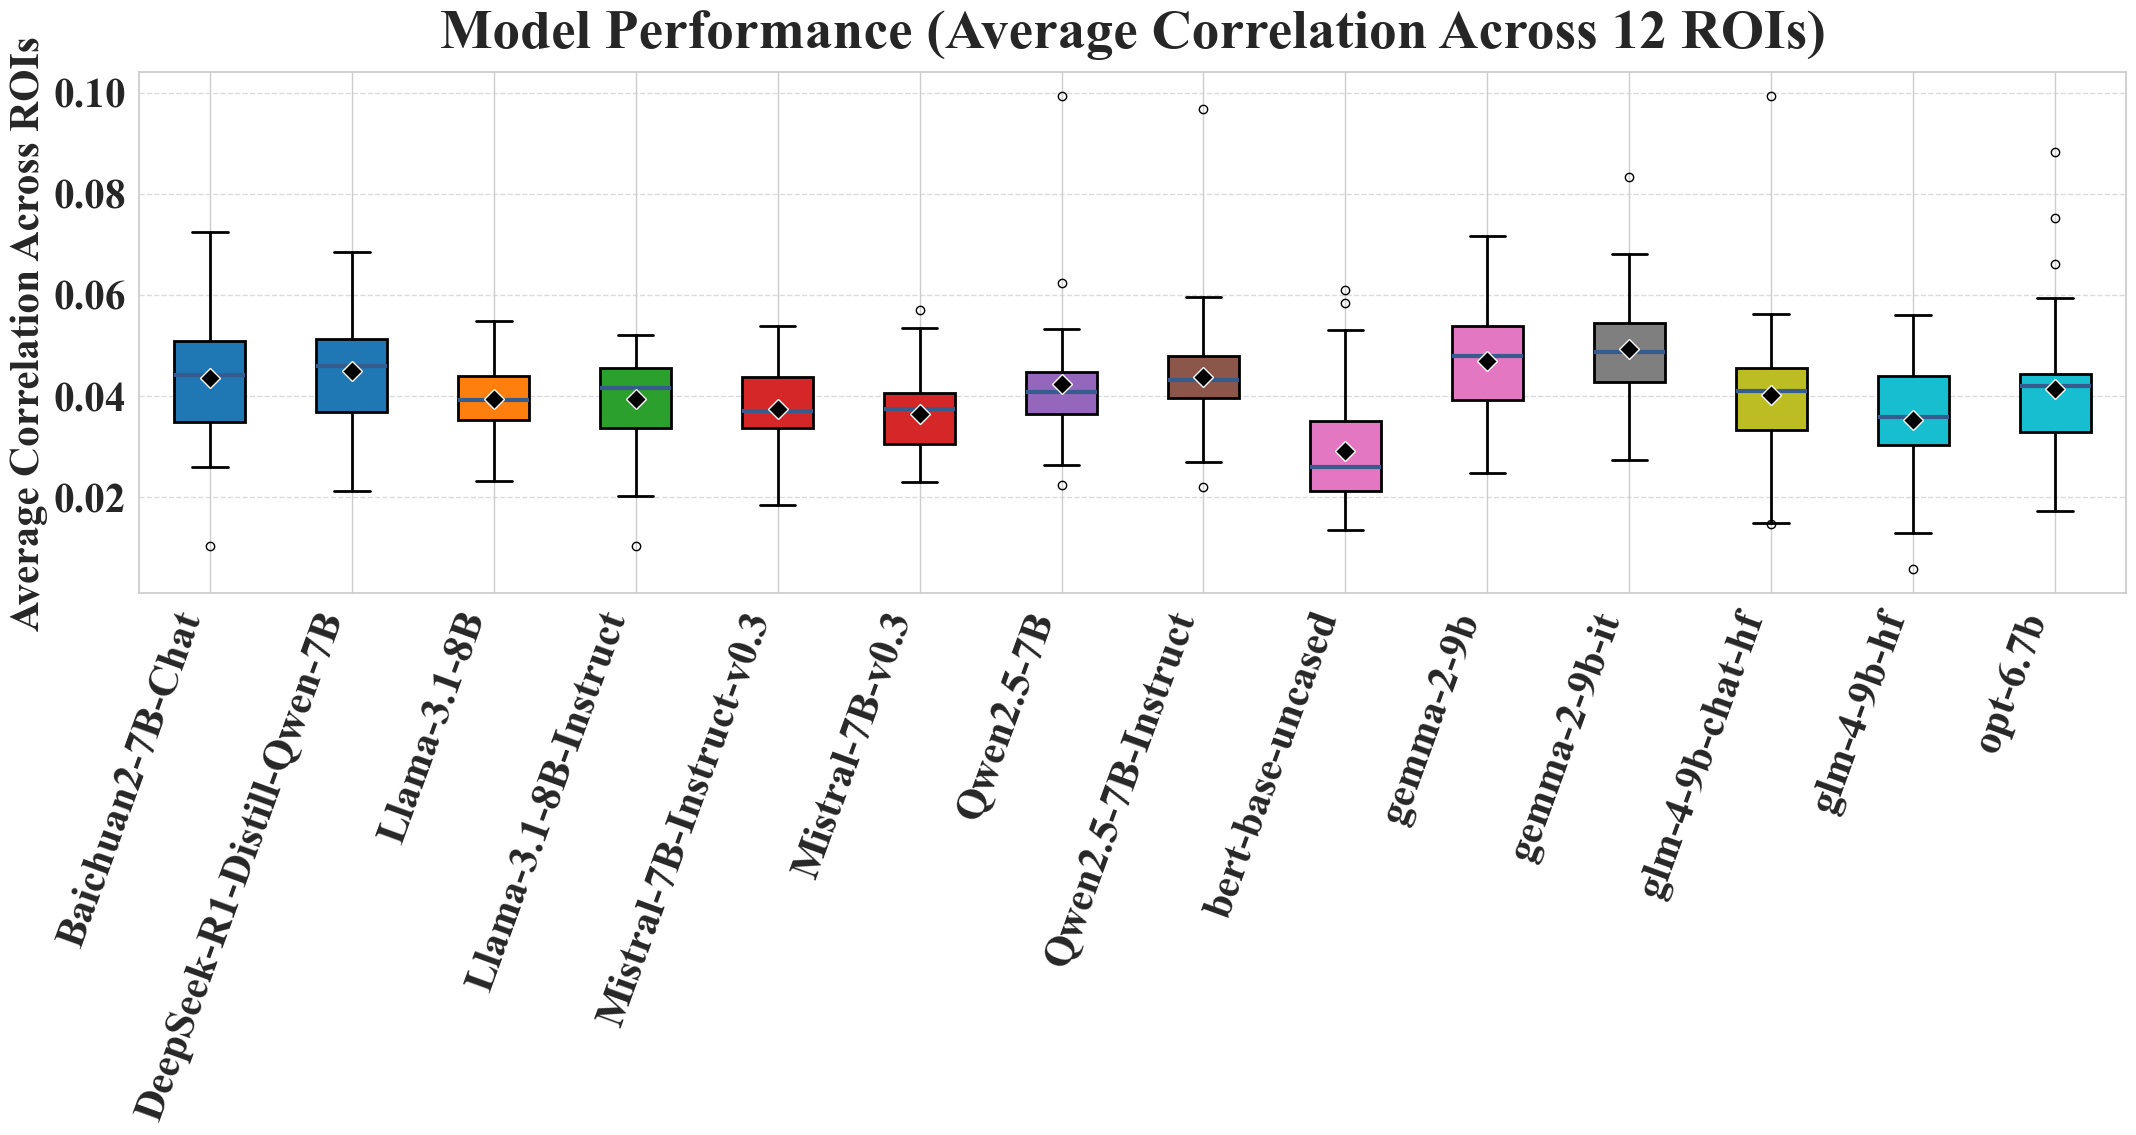

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Global font: Times New Roman + Bold + Large size
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 28,           # Base font size ≥22
    'font.weight': 'bold',
    'axes.labelsize': 28,
    'axes.titlesize': 30,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.labelsize': 28,
    'ytick.labelsize': 28,
    'legend.fontsize': 28,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Configuration parameters
base_path = 'results_language_scheme1/'
rois = ['LH_AngG', 'LH_AntTemp', 'LH_IFG', 'LH_IFGorb', 'LH_MFG', 'LH_PostTemp',
        'RH_AngG', 'RH_AntTemp', 'RH_IFG', 'RH_IFGorb', 'RH_MFG', 'RH_PostTemp']
models = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

average_correlation_data = []
for model in models:
    model_path = os.path.join(base_path, model)
    for subj in range(34):
        roi_corrs = []
        for roi in rois:
            file_path = os.path.join(model_path, f'subj_{subj}_{roi}.npz')
            if not os.path.exists(file_path):
                continue
            data = np.load(file_path)
            correlations = data['correlations']
            best_layer_corr = np.nanmax(correlations)
            roi_corrs.append(best_layer_corr)
        if roi_corrs:
            avg_corr = np.nanmean(roi_corrs)
            average_correlation_data.append({
                'Model': model,
                'Subject': subj,
                'AvgCorrelation': avg_corr
            })

df = pd.DataFrame(average_correlation_data)
model_avg_corrs = df.groupby('Model')['AvgCorrelation'].apply(list)

# Increase canvas size and add bottom margin to accommodate large X-axis labels
plt.figure(figsize=(22, 12))
plt.subplots_adjust(bottom=0.28)

# Thicker boxplot style + show mean points
box = plt.boxplot(
    model_avg_corrs,
    patch_artist=True,
    vert=True,
    showmeans=True,
    meanprops={'marker': 'D', 'markerfacecolor': 'black', 'markeredgecolor': 'white', 'markersize': 10},
    medianprops={'linewidth': 3},
    whiskerprops={'linewidth': 2},
    capprops={'linewidth': 2},
    boxprops={'linewidth': 2}
)

# Color scheme
colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Axis labels and title (Bold + Large size)
plt.xticks(
    range(1, len(models) + 1),
    model_avg_corrs.index,
    rotation=70,
    ha='right',
    fontsize=30,
    fontweight='bold'
)
plt.ylabel('Average Correlation Across ROIs', fontsize=30, fontweight='bold')
plt.title('Model Performance (Average Correlation Across 12 ROIs)', fontsize=40, fontweight='bold', pad=18)
plt.yticks(fontsize=30, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('boxplot_model_avg_correlation.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Figure 6

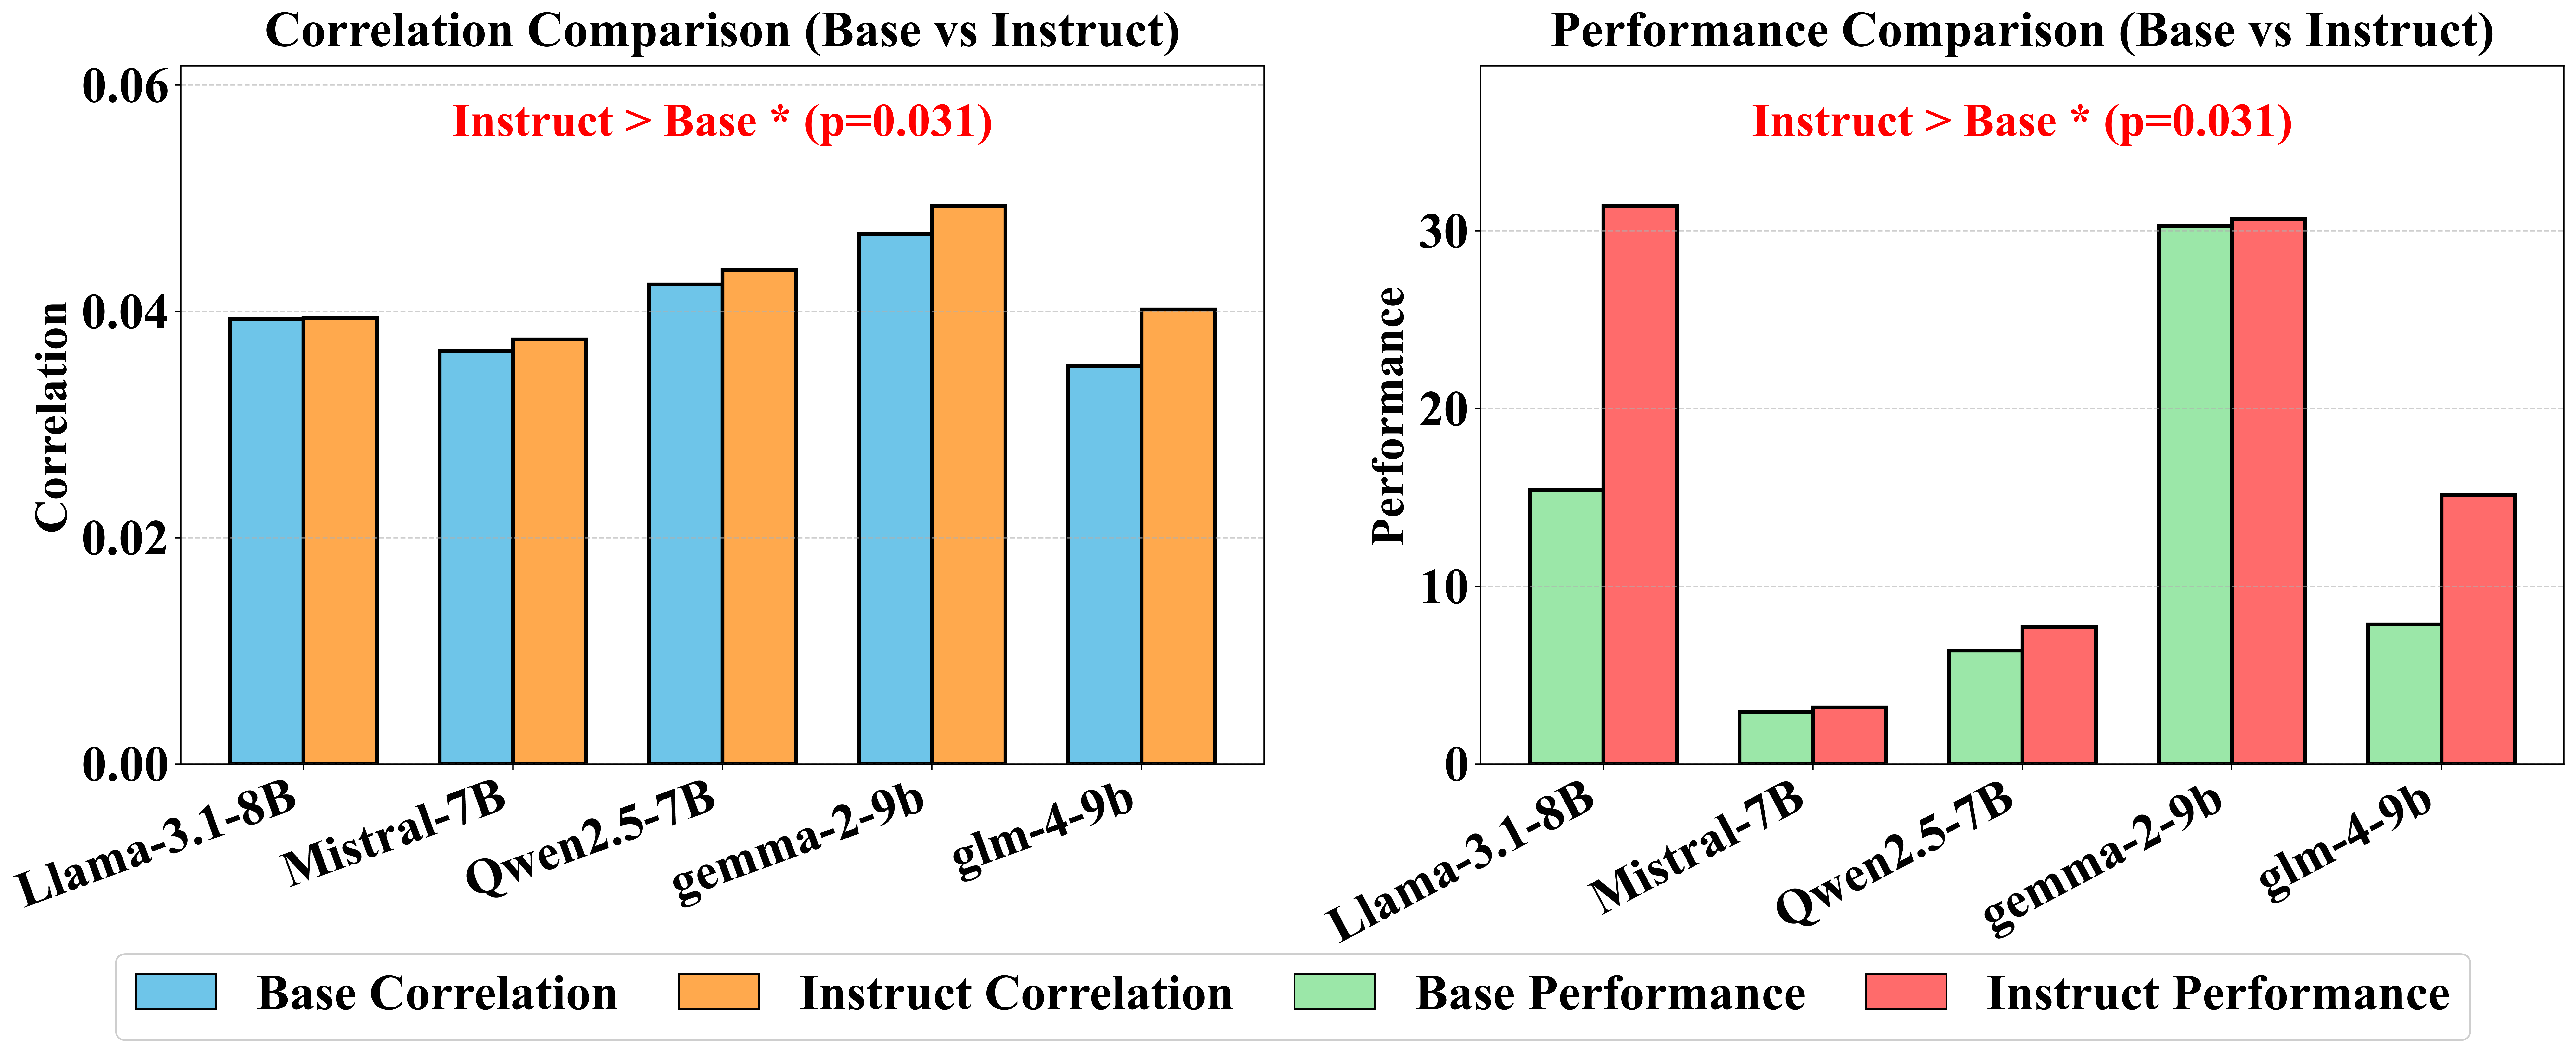

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Global font and output settings
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 28,
    'font.weight': 'bold',
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'xtick.labelsize': 30,
    'ytick.labelsize': 30,
    'legend.fontsize': 30,
    'pdf.fonttype': 42,
    'ps.fonttype': 42
})

# Data
data = {
    "Model": ["Llama-3.1-8B", "Mistral-7B", "Qwen2.5-7B", "gemma-2-9b", "glm-4-9b"],
    "Base_Corr": [0.039364, 0.036505, 0.042396, 0.046857, 0.035206],
    "Instruct_Corr": [0.039414, 0.037541, 0.043682, 0.049349, 0.040182],
    "Base_Perf": [15.41, 2.94, 6.40, 30.29, 7.87],
    "Instruct_Perf": [31.42, 3.20, 7.74, 30.69, 15.14]
}
df = pd.DataFrame(data)

# p-values (example)
corr_pval = 0.03125
perf_pval = 0.03125

def p_to_stars(p):
    return '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'n.s.'

# Canvas and subplots
fig, ax = plt.subplots(1, 2, figsize=(22, 10), dpi=500)
plt.subplots_adjust(left=0.08, right=0.98, top=0.8, bottom=0.22)  # Reserve top for p-values, bottom for legend

# Parameters
title_params = {'fontsize': 30, 'fontweight': 'bold', 'pad': 12}
label_params = {'fontsize': 28, 'fontweight': 'bold'}
text_params = {'fontsize': 28, 'fontweight': 'bold', 'color': 'red', 'ha': 'center'}

width = 0.35
x = np.arange(len(df))

# Colors
bar_colors1 = ['#6EC5E9', '#FFA94D']   # corr: base / instruct
bar_colors2 = ['#9BE7A8', '#FF6B6B']   # perf: base / instruct

# -------- Subplot 1: Correlation --------
ax[0].bar(x - width/2, df['Base_Corr'], width, color=bar_colors1[0], edgecolor='black', linewidth=2.2, label='Base Correlation')
ax[0].bar(x + width/2, df['Instruct_Corr'], width, color=bar_colors1[1], edgecolor='black', linewidth=2.2, label='Instruct Correlation')

corr_max = max(df['Base_Corr'].max(), df['Instruct_Corr'].max())
ax[0].set_ylim(0, corr_max * 1.25)  # Reserve top space
ax[0].set_title("Correlation Comparison (Base vs Instruct)", **title_params)
ax[0].set_ylabel("Correlation", **label_params)
ax[0].set_xticks(x)
ax[0].set_xticklabels(df['Model'], rotation=20, ha='right', fontweight='bold')
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# Place p-value above the axis (without blocking)
ax[0].text(0.5, 0.90,
           f"Instruct > Base {p_to_stars(corr_pval)} (p={corr_pval:.3f})",
           transform=ax[0].transAxes, clip_on=False, **text_params)

# -------- Subplot 2: Performance --------
ax[1].bar(x - width/2, df['Base_Perf'], width, color=bar_colors2[0], edgecolor='black', linewidth=2.2, label='Base Performance')
ax[1].bar(x + width/2, df['Instruct_Perf'], width, color=bar_colors2[1], edgecolor='black', linewidth=2.2, label='Instruct Performance')

perf_max = max(df['Base_Perf'].max(), df['Instruct_Perf'].max())
ax[1].set_ylim(0, perf_max * 1.25)
ax[1].set_title("Performance Comparison (Base vs Instruct)", **title_params)
ax[1].set_ylabel("Performance", **label_params)
ax[1].set_xticks(x)
ax[1].set_xticklabels(df['Model'], rotation=28, ha='right', fontweight='bold')
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

ax[1].text(0.5, 0.90,
           f"Instruct > Base {p_to_stars(perf_pval)} (p={perf_pval:.3f})",
           transform=ax[1].transAxes, clip_on=False, **text_params)

# -------- Place shared legend at bottom outside the plot --------
legend_handles = [
    mpatches.Patch(facecolor=bar_colors1[0], edgecolor='black', label='Base Correlation'),
    mpatches.Patch(facecolor=bar_colors1[1], edgecolor='black', label='Instruct Correlation'),
    mpatches.Patch(facecolor=bar_colors2[0], edgecolor='black', label='Base Performance'),
    mpatches.Patch(facecolor=bar_colors2[1], edgecolor='black', label='Instruct Performance')
]
fig.legend(legend_handles, [h.get_label() for h in legend_handles],
           loc='lower center', bbox_to_anchor=(0.5, -0.03),
           ncol=4, frameon=True, framealpha=0.95, columnspacing=1.2, handlelength=1.6)

plt.savefig('Instruct-Base.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Figure 7

未匹配Performance数据的模型: ['bert-base-uncased']


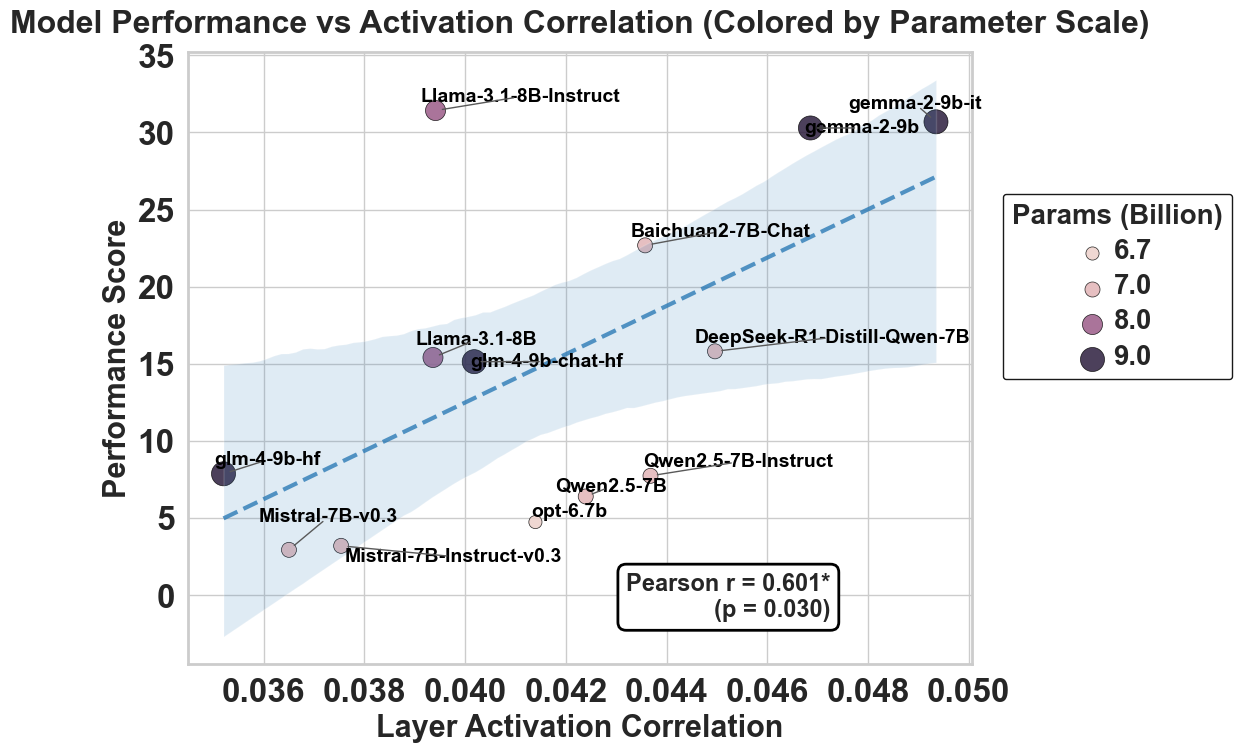

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Optional: for automatic text avoidance (to prevent model name overlapping)
try:
    from adjustText import adjust_text
    HAS_ADJUST = True
except ImportError:
    HAS_ADJUST = False
    print("Note: adjustText not installed, automatic label adjustment unavailable. Run `pip install adjustText` for better results.")

# ================== Data Processing ==================
base_path = 'results_language_scheme1/'
rois = ['LH_AngG', 'LH_AntTemp', 'LH_IFG', 'LH_IFGorb', 'LH_MFG', 'LH_PostTemp',
        'RH_AngG', 'RH_AntTemp', 'RH_IFG', 'RH_IFGorb', 'RH_MFG', 'RH_PostTemp']

models = sorted([d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))])

best_layer_data = []
for model in models:
    model_path = os.path.join(base_path, model)
    for roi in rois:
        subject_max_corrs = []
        for subj in range(34):
            file_path = os.path.join(model_path, f'subj_{subj}_{roi}.npz')
            if not os.path.exists(file_path):
                continue
            data = np.load(file_path)
            correlations = data['correlations']
            best_layer_corr = np.nanmax(correlations)
            subject_max_corrs.append(best_layer_corr)
        for corr in subject_max_corrs:
            best_layer_data.append({'Model': model, 'ROI': roi, 'Correlation': corr})

df = pd.DataFrame(best_layer_data)

performance = {
    'Meta-Llama-3.1-8B-Instruct': 31.42,
    'gemma-2-9b-Instruct': 30.69,
    'gemma-2-9b': 30.29,
    'Baichuan2-7B-Chat': 22.68,
    'DeepSeek-R1-Distill': 15.81,
    'Llama-3.1-8B': 15.41,
    'glm-4-9b-chat': 15.14,
    'Qwen2.5-7B-Instruct': 7.74,
    'glm-4-9b': 7.87,
    'Qwen2.5-7B': 6.40,
    'opt-6.7b': 4.74,
    'Mistral-7B-Instruct': 3.20,
    'Mistral-7B': 2.94
}
key_mapping = {
    'Meta-Llama-3.1-8B-Instruct': 'Llama-3.1-8B-Instruct',
    'gemma-2-9b-Instruct': 'gemma-2-9b-it',
    'gemma-2-9b': 'gemma-2-9b',
    'Baichuan2-7B-Chat': 'Baichuan2-7B-Chat',
    'DeepSeek-R1-Distill': 'DeepSeek-R1-Distill-Qwen-7B',
    'Llama-3.1-8B': 'Llama-3.1-8B',
    'glm-4-9b-chat': 'glm-4-9b-chat-hf',
    'Qwen2.5-7B-Instruct': 'Qwen2.5-7B-Instruct',
    'glm-4-9b': 'glm-4-9b-hf',
    'Qwen2.5-7B': 'Qwen2.5-7B',
    'opt-6.7b': 'opt-6.7b',
    'Mistral-7B-Instruct': 'Mistral-7B-Instruct-v0.3',
    'Mistral-7B': 'Mistral-7B-v0.3'
}
corrected_performance = {key_mapping.get(k, k): v for k, v in performance.items()}

model_avg_corr = df.groupby('Model')['Correlation'].mean().reset_index()

performance_df = pd.DataFrame({
    'Model': list(corrected_performance.keys()),
    'Performance': list(corrected_performance.values())
})

merged_df = pd.merge(model_avg_corr, performance_df, on='Model', how='left')

unmatched_models = merged_df[merged_df['Performance'].isna()]['Model'].tolist()
print("Models without matched Performance data:", unmatched_models)

# Add .copy() to avoid SettingWithCopyWarning
merged_df_clean = merged_df.dropna(subset=['Performance']).copy()
param_mapping = {
    'Baichuan-7B': 7, 'Baichuan2-7B-Chat': 7, 'DeepSeek-R1-Distill-Qwen-7B': 7,
    'Llama-3.1-8B': 8, 'Llama-3.1-8B-Instruct': 8,
    'Mistral-7B-Instruct-v0.3': 7, 'Mistral-7B-v0.3': 7,
    'Qwen2.5-7B': 7, 'Qwen2.5-7B-Instruct': 7, 'gemma-2-9b': 9, 'gemma-2-9b-it': 9,
    'glm-4-9b-chat-hf': 9, 'glm-4-9b-hf': 9, 'opt-6.7b': 6.7
}
merged_df_clean.loc[:, 'Params(B)'] = merged_df_clean['Model'].map(param_mapping)

# ================== Plot Beautification ==================
# Global font
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 22
rcParams['font.weight'] = 'bold'
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelweight'] = 'bold'
rcParams['xtick.labelsize'] = 24   # Tick font size 24
rcParams['ytick.labelsize'] = 24   # Tick font size 24
rcParams['legend.fontsize'] = 22
rcParams['legend.title_fontsize'] = 22

plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid", palette="viridis")

scatter = sns.scatterplot(
    data=merged_df_clean,
    x='Correlation',
    y='Performance',
    hue='Params(B)',
    size='Params(B)',
    sizes=(90, 300),
    alpha=0.85,
    linewidth=0.5,
    edgecolor='k'
)

sns.regplot(
    x=merged_df_clean['Correlation'],
    y=merged_df_clean['Performance'],
    scatter=False,
    color='#2c7bb6',
    line_kws={'lw': 3, 'alpha': 0.8, 'ls': '--'}
)

ax = plt.gca()

# Explicitly set tick text to bold again (ensure bold takes effect)
for lbl in ax.get_xticklabels() + ax.get_yticklabels():
    lbl.set_fontsize(24)
    lbl.set_fontweight('bold')

# Model labels + automatic adjustment
top_models = merged_df_clean.nlargest(18, 'Performance')
texts = []
for _, row in top_models.iterrows():
    t = ax.text(
        row['Correlation'], row['Performance'],
        row['Model'],
        fontsize=14, fontweight='bold',
        ha='left', va='bottom', color='black'
    )
    texts.append(t)

if HAS_ADJUST and len(texts) > 0:
    adjust_text(
        texts,
        x=merged_df_clean['Correlation'],
        y=merged_df_clean['Performance'],
        only_move={'points': 'xy', 'text': 'xy'},
        expand_points=(1.2, 1.2),
        expand_text=(1.2, 1.4),
        force_text=0.8,
        arrowprops=dict(arrowstyle='-', color='0.35', lw=1, shrinkA=5, shrinkB=5)
    )

# Merge r and p into one box and move down
stats_text = 'Pearson r = 0.601*\n(p = 0.030)'
ax.text(
    0.82, 0.15,
    stats_text,
    transform=ax.transAxes,
    ha='right', va='top',
    fontsize=17, fontweight='bold',
    bbox=dict(boxstyle='round,pad=0.35', facecolor='white', edgecolor='black', linewidth=2)
)

# Title and axis labels
plt.title('Model Performance vs Activation Correlation (Colored by Parameter Scale)',
          fontsize=23, fontweight='bold', pad=14)
plt.xlabel('Layer Activation Correlation', fontsize=22, fontweight='bold')
plt.ylabel('Performance Score', fontsize=22, fontweight='bold')

# Thicken axis ticks and borders
ax.tick_params(axis='both', which='both', width=2)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Legend: explicitly force 22pt bold
legend = ax.legend(
    title='Params (Billion)',
    frameon=True, framealpha=0.9, edgecolor='black',
    loc='upper left',
    bbox_to_anchor=(1.03, 0.78),
    borderpad=0.6,
    handlelength=1.2,
    labelspacing=0.6
)
legend.get_title().set_fontsize(20)
legend.get_title().set_fontweight('bold')
for txt in legend.get_texts():
    txt.set_fontsize(20)
    txt.set_fontweight('bold')

plt.tight_layout(pad=2.0)
plt.savefig('Performance_Activation.pdf', format='pdf', dpi=400, bbox_inches='tight', transparent=False)
plt.show()